# Instructions
Using saas.csv or log data from API usage or store_item_sales:
1. Split data (train/validate/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    * Simple Average
    * Moving Average
    * Holt's Linear Trend Model
    * Based on previous year/month/etc., this is up to you.

Optional: Using store item demand
1. Predict 2018 total monthly sales for a single store and/or item by creating a model.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.

# Saas.CSV

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

import statsmodels.tsa.api as sm

In [2]:
# cache data
df = pd.read_csv('saas.csv')
df

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...,...
790453,2017-12-31,1029395,5790453,0.0,0.0
790454,2017-12-31,1029396,5790454,0.0,0.0
790455,2017-12-31,1029397,5790455,3.0,15.0
790456,2017-12-31,1029398,5790456,0.0,0.0


In [3]:
# assign date to index
df['Month_Invoiced'] = df['Month_Invoiced'].astype('datetime64')
df.index = df.Month_Invoiced

In [4]:
# create monthly dataframe
monthly_df = df[['Amount']].resample('M').sum()
monthly_df.head(3)

,Amount
Month_Invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0


<AxesSubplot:xlabel='Month_Invoiced'>

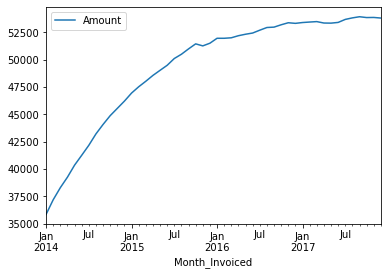

In [5]:
# check distribution
monthly_df.plot()

In [6]:
# slice for recent data (higher-accuracy predictions)
monthly_df = monthly_df['2016':]

In [7]:
# create masks for 12mo, 6mo, and 6mo splits
train_mask = monthly_df.index.year == 2016
validate_mask = (monthly_df.index.year == 2017) & (monthly_df.index.month < 7)
test_mask = (monthly_df.index.year == 2017) & (monthly_df.index.month >= 7)
# split into 12 month train, 6 month validate, 6 month test
train = monthly_df[train_mask]
validate = monthly_df[validate_mask]
test = monthly_df[test_mask]
# check results
len(train) + len(validate) + len(test) == len(monthly_df)

True

In [8]:
# simple average
validate['simple_average'] = train.Amount.mean()
# rolling average
validate['quarterly_rolling'] = train.Amount.rolling(3).mean()[-1]
# Holt's linear trend
model = sm.Holt(train['Amount'], exponential = False)
model = model.fit(smoothing_level = .1, smoothing_slope = .1, optimized = False)
validate['Holt_0.1_0.1'] = model.predict(start = validate.index[0], 
                                       end = validate.index[-1])
# Semi-Annual Difference
mean_6mo_diff = train.Amount.diff(6).mean()
validate['semi_annual_diff'] = list(train[6:].Amount)
validate['semi_annual_diff'] = validate['semi_annual_diff'] + mean_6mo_diff

<AxesSubplot:xlabel='Month_Invoiced'>

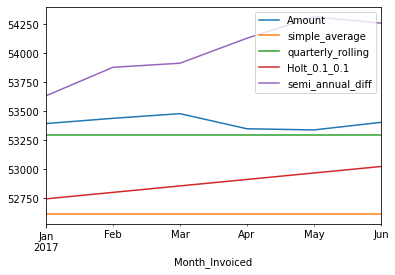

In [9]:
validate.plot()

In [10]:
# evaluate RMSE
for col in validate.columns[1:]:
    print(col + ' RMSE:\n' + str(round(sqrt(mean_squared_error(validate['Amount'], validate[col])), 0)))

simple_average RMSE:
790.0
quarterly_rolling RMSE:
117.0
Holt_0.1_0.1 RMSE:
530.0
semi_annual_diff RMSE:
674.0
